In [1]:
import pandas as pd
import numpy as np
import quandl, datetime
import math
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import style
import pickle

style.use('ggplot')

In [2]:
df = pd.read_pickle("data/googl.pkl")

In [3]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume',]]

df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0
2004-08-20,54.322689,7.921706,7.227007,22834300.0
2004-08-23,54.869377,4.049360,-1.227880,18256100.0
2004-08-24,52.597363,7.657099,-5.726357,15247300.0
2004-08-25,53.164113,3.886792,1.183658,9188600.0


In [4]:
forecast_col = 'Adj. Close'

df.fillna(-99999, inplace = True)

forecast_out = int(math.ceil(0.01 * len(df)))

df['label'] = df[forecast_col].shift(-forecast_out)

df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0,69.078238
2004-08-20,54.322689,7.921706,7.227007,22834300.0,67.839414
2004-08-23,54.869377,4.049360,-1.227880,18256100.0,68.912727
2004-08-24,52.597363,7.657099,-5.726357,15247300.0,70.668146
2004-08-25,53.164113,3.886792,1.183658,9188600.0,71.219849


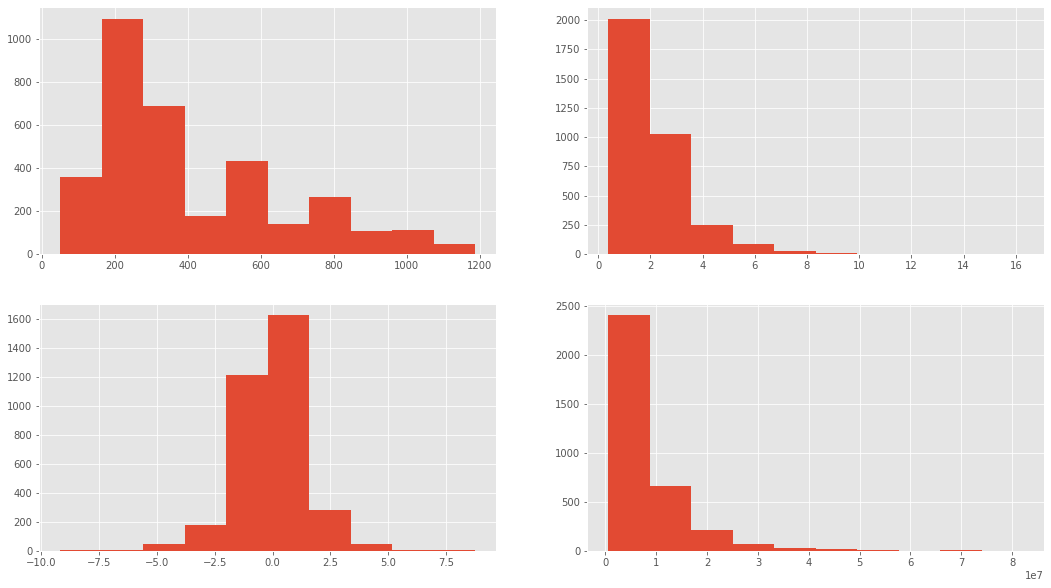

In [5]:
fig, ax = plt.subplots(2, 2, figsize = (18, 10))
ax[0, 0] = ax[0, 0].hist(df['Adj. Close'])
ax[0, 1] = ax[0, 1].hist(df['HL_PCT'])
ax[1, 0] = ax[1, 0].hist(df['PCT_change'])
ax[1, 1] = ax[1, 1].hist(df['Adj. Volume'])
plt.show()

In [6]:
def model(X, Y, learning_rate, epochs):
    w = np.zeros((1, X.shape[0]))
    b = np.zeros((1, X.shape[1]))
    m = X.shape[1]
    
    for i in range(epochs):
        h = np.dot(w, X) + b
        cost = np.sum((h - Y)**2)/(2*m) 
        print("cost at iteration", i, ":", cost)
        dw = -np.dot((h - Y), X.T)/m
        db = -(h - Y) / m
        w -= (learning_rate * dw)
        b -= (learning_rate * db)
    
    return w, b

In [7]:
X = np.array(df.drop(['label'], 1))

/tmp/ipykernel_8657/2899627998.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df.drop(['label'], 1))


In [8]:
X = preprocessing.scale(X)
before_X = X[:-forecast_out]
X_lately = X[-forecast_out:]
before_X = preprocessing.scale(before_X)
df.dropna(inplace = True)
y = np.array(df['label']).reshape(-1, 1)

In [9]:
X = before_X

In [10]:
trainx, testx, trainy, testy = train_test_split(X, y, test_size = 0.2)

In [11]:
reg = LinearRegression()
reg.fit(trainx, trainy)
reg.score(testx, testy)

0.9790632751197428

<AxesSubplot:xlabel='Date'>

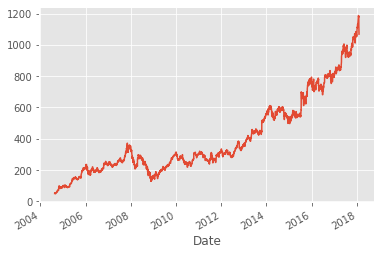

In [12]:
df['Adj. Close'].plot()

In [13]:
last_date = df.iloc[-1].name
one_day = 86400
last_unix = last_date.timestamp()
next_unix = last_unix + one_day

In [14]:
forecast_set = reg.predict(X_lately)
df['forecast'] = np.nan

In [15]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

In [16]:
df

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label,forecast
Date,,,,,,
2004-08-19 00:00:00,50.322842,8.072956,0.324968,44659000.0,69.078238,NaN
2004-08-20 00:00:00,54.322689,7.921706,7.227007,22834300.0,67.839414,NaN
2004-08-23 00:00:00,54.869377,4.049360,-1.227880,18256100.0,68.912727,NaN
2004-08-24 00:00:00,52.597363,7.657099,-5.726357,15247300.0,70.668146,NaN
2004-08-25 00:00:00,53.164113,3.886792,1.183658,9188600.0,71.219849,NaN
...,...,...,...,...,...,...
2018-03-08 05:30:00,NaN,NaN,NaN,NaN,NaN,[1081.359911427755]
2018-03-09 05:30:00,NaN,NaN,NaN,NaN,NaN,[1038.4786865979968]
2018-03-10 05:30:00,NaN,NaN,NaN,NaN,NaN,[1011.723852634659]


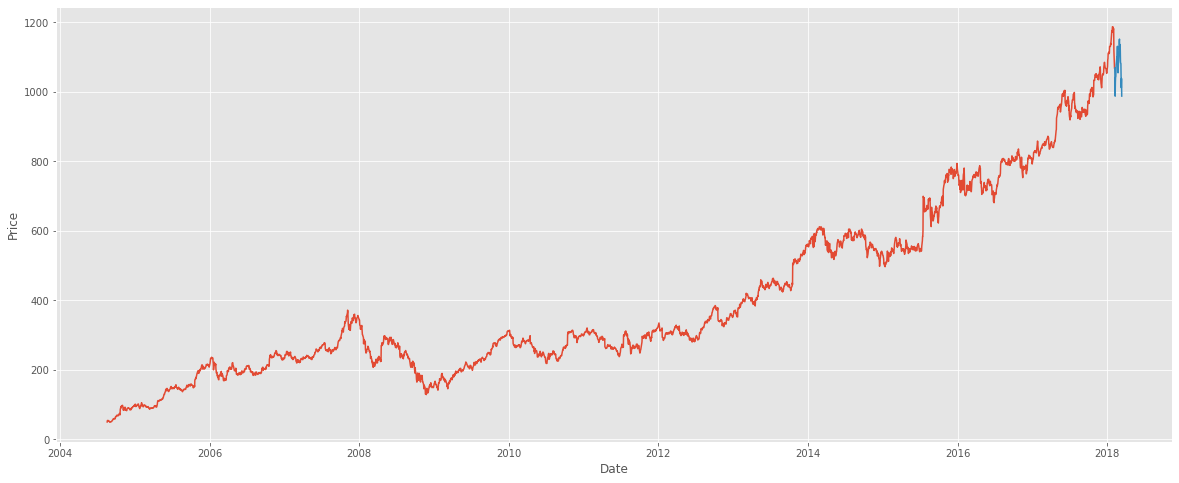

In [17]:
fig = plt.figure(figsize = (20, 8))
plt.plot(df[:-forecast_out].index, df[:-forecast_out]['Adj. Close'])
plt.plot(df[-forecast_out:].index, df[-forecast_out:]['forecast'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()